# Network Classification

In [1]:
# Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import math
from random import *

## Measures used 

In [2]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

In [3]:
def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

In [4]:
def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M

In [5]:
def measures(G):
    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    
    # Momment of degree
    k1 = momment_of_degree_distribution(G,1) 
    k2 = momment_of_degree_distribution(G,2)
    # Variance
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    # Shannon entropy
    S = shannon_entropy(G)
    # Average clustering
    av_cl = nx.average_clustering(G)
    # Average shortest path lenght
    l = nx.average_shortest_path_length(G)
    # Network efficiency
    E = nx.global_efficiency(G)
    # Average local efficiency
    leff = nx.local_efficiency(G)
    # Average closeness centrality
    CLC = dict(nx.closeness_centrality(G))
    CLC = list(CLC.values())
    av_clc = np.mean(CLC)
    # Average betweenness centrality
    B = dict(nx.betweenness_centrality(G))
    B = list(B.values())
    av_B = np.mean(B)
    # Average eigenvector centrality
    EC = dict(nx.eigenvector_centrality(G, max_iter = 10000))
    EC = list(EC.values())
    av_EC = np.mean(EC)
    # Assortativity 
    r=nx.degree_assortativity_coefficient(G)
    
    return  [k1,k2,S,variance,av_cl,l,E,leff,av_clc, av_B,av_EC,r]

## Network models

In [6]:
def networks_generation(N,measure_):
    from networkx.utils import powerlaw_sequence
    # measures from the network we want to classife:
    X_net = measure_
    print('X_net:',X_net)
    
    # Networks we gone generate for classification:
    cl = ['Erdos-Renyi','Small World','Barabási-Albert','Random Lobster','Configuration model','Growing network']
    
    # Erdos-Renyi network
    X = []
    y = []
    n_nets = 30
    av_degree = measure_[0]
    p = av_degree/(N-1)
    for i in range(0,n_nets):
        GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        x = measures(GER)
        X.append(x)
        y.append(0.0)

    # Small World network
    k = int(av_degree)
    p = 0.1 #probability of rewiring
    for i in range(0,n_nets):
        GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
        Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
        GWS = GWS.subgraph(Gcc[0])
        GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        x = measures(GWS)
        X.append(x)
        y.append(1.0)

    # Barabási-Albert network
    m = int(av_degree/2)
    for i in range(0,n_nets):
        GBA = nx.barabasi_albert_graph(N, m)    
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        x = measures(GBA)
        X.append(x)
        y.append(2.0)
    
    # Random Lobster network
    for i in range(0,n_nets):
        GRL = nx.random_lobster(N,0.5,0.5)
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        x = measures(GBA)
        X.append(x)
        y.append(3.0)
        
    # Configuration model network
    for i in range(0,n_nets):
        #sequence = nx.random_powerlaw_tree_sequence(N)
        a = 3
        sequence = np.random.zipf(a, N) #Zipf distribution

        if(sum(sequence)%2 != 0): # the sum of stubs have to be even
            pos = randint(0, len(sequence))
            sequence[pos] = sequence[pos]+ 1
        
        GCM = nx.configuration_model(sequence)
        GCM = nx.Graph(GCM)
        Gcc = sorted((GCM.subgraph(c) for c in nx.connected_components(GCM)), key = len, reverse=True)
        GCM = Gcc[0]
        GCM = nx.convert_node_labels_to_integers(GCM, first_label=0)
        x = measures(GCM)
        X.append(x)
        y.append(4.0)
        
    # Growing network
    for i in range(0,n_nets):
        GGN = nx.gn_graph(N)
        GGN = nx.Graph(GGN)
        Gcc = sorted((GCM.subgraph(c) for c in nx.connected_components(GGN)), key = len, reverse=True)
        GGN = Gcc[0]
        GGN = nx.convert_node_labels_to_integers(GGN, first_label=0)
        x = measures(GGN)
        X.append(x)
        y.append(5.0)
        
    X = np.array(X)
    y = np.array(y)
    
    return X_net,X,y, cl

## Machine learning models

In [7]:
def network_classification(X_net,X,y,cl):
    measures_names = ['Momment of degree 1','Momment of degree 2','Variance','Shannon entropy','Average clustering',
                 'Average shortest path lenght','Network efficiency','Average local efficiency','Average closeness centrality',
                 'Average betweenness centrality','Average eigenvector centrality','Assortativity']
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_net = np.array(X_net)
    X_net = X_net.reshape(1,len(X_net)) 
    X_net = scaler.transform(X_net)
    #print('Xnet:', X_net.shape)

    # NaiveBayes
    ####################
    NB = GaussianNB()
    NB.fit(X, y)
    y_pred_NB = NB.predict(X_net)
    print('\n',NB,':', cl[int(y_pred_NB)])
    
    # K Neighbors
    ####################
    k = 5
    KN = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    KN.fit(X,y)
    # faz a predição no conjunto de teste
    y_pred_KN = KN.predict(X_net)
    print('\n',KN,':', cl[int(y_pred_KN)])
    
    # Logist Regression
    ####################
    LR = LogisticRegression(multi_class = 'auto', max_iter = 1000)
    LR.fit(X, y)
    y_pred_LR = LR.predict(X_net)
    print('\n',LR,':', cl[int(y_pred_LR)])
    
    # Random Flortest
    ####################
    RF = RandomForestClassifier(random_state=0)
    RF.fit(X,y)
    y_pred_RF = RF.predict(X_net)
    print('\n',RF,':', cl[int(y_pred_RF)])
    print("Top 5 measures:")
    df_RF = pd.DataFrame({'Measures':measures_names,'Importance':RF.feature_importances_})    
    df_RF = df_RF.sort_values('Importance', ascending=False)
    print(df_RF.head())
    
    # Decision Tree
    ####################
    DT = DecisionTreeClassifier(random_state=0)
    DT.fit(X,y)
    y_pred_DT = DT.predict(X_net)
    print('\n',DT,':', cl[int(y_pred_DT)])
    #print(DT.feature_importances_)
    print("Top 5 measures:")
    df_DT = pd.DataFrame({'Measures':measures_names,'Importance':DT.feature_importances_})    
    df_DT = df_DT.sort_values('Importance', ascending=False)
    print(df_DT.head())

## Load 

In [8]:
def load_the_network(df):
    print(df.head())
    G = nx.from_pandas_edgelist(df, source = df.columns.values[0], target = df.columns.values[1])
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    N = len(G)
    M = G.number_of_edges()
    print('\nNumber of nodes:', N)
    print('Number of edges:', M)
    
    measure_ = measures(G)
    X_net,X,y,cl = networks_generation(N,measure_)
    network_classification(X_net,X,y,cl)
    
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color="b", node_size=50, with_labels=False)

## Classification of social network

### Game of Thrones coappearances

    Description:
        Network of coappearances of characters in the Game of Thrones series, by George R. R. Martin, and in particular coappearances in the book "A Storm of Swords." Nodes are unique characters, and edges are weighted by the number of times the two characters' names appeared within 15 words of each other in the text
        
    link -> https://networks.skewed.de/net/game_thrones

  Source   Target  Weight
0  Aemon    Grenn       5
1  Aemon  Samwell      31
2  Aerys    Jaime      18
3  Aerys   Robert       6
4  Aerys   Tyrion       5

Number of nodes: 107
Number of edges: 352
X_net: [6.579439252336448, 86.59813084112149, 3.7151527599038605, 43.30910996593588, 0.551443151559996, 2.903897019925939, 0.398330688297185, 0.6612406793567985, 0.3547361494913039, 0.018132352570723227, 0.0646751374100777, -0.13076968366930292]

 GaussianNB() : Configuration model

 KNeighborsClassifier(metric='euclidean') : Barabási-Albert

 LogisticRegression(max_iter=1000) : Barabási-Albert

 RandomForestClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                          Measures  Importance
11                   Assortativity    0.128852
2                         Variance    0.123168
9   Average betweenness centrality    0.100118
3                  Shannon entropy    0.090431
0              Momment of degree 1    0.088738

 DecisionTreeClassifier(random_state=0) : Erd

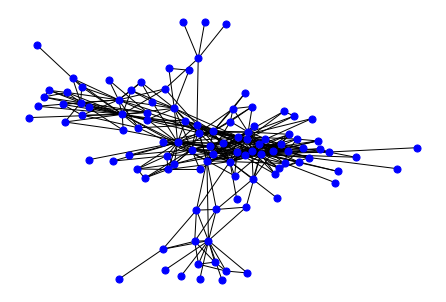

In [17]:
GoT = pd.read_csv("data/social/stormofswords.csv")
load_the_network(GoT)

### Aarhus Computer Science department relationships

    Description:
        Multiplex network consisting of 5 edge types corresponding to online and offline relationships (Facebook, leisure, work, co-authorship, lunch) between employees of the Computer Science department at Aarhus. Data hosted by Manlio De Domenico.
        
    link -> https://networks.skewed.de/net/cs_department

    1   2
0   1   2
1   1   3
2  10  11
3  10  14
4  10  15

Number of nodes: 61
Number of edges: 353
X_net: [11.573770491803279, 168.98360655737704, 4.233638264240398, 35.031443160440745, 0.5916203249211789, 2.0628415300546448, 0.5540528233151089, 0.7637011088898903, 0.4934840765715131, 0.01801426322126516, 0.10959992637083121, 0.05355525498992259]

 GaussianNB() : Erdos-Renyi

 KNeighborsClassifier(metric='euclidean') : Barabási-Albert

 LogisticRegression(max_iter=1000) : Barabási-Albert

 RandomForestClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                         Measures  Importance
9  Average betweenness centrality    0.113915
0             Momment of degree 1    0.111506
3                 Shannon entropy    0.104782
1             Momment of degree 2    0.101672
7        Average local efficiency    0.096681

 DecisionTreeClassifier(random_state=0) : Random Lobster
Top 5 measures:
                          Measures  Importance
1              Momment of degree

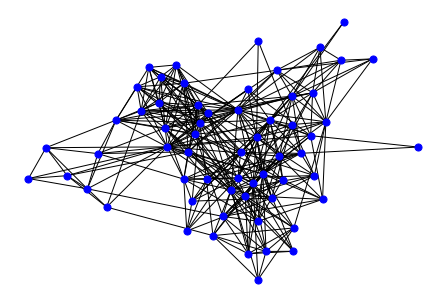

In [19]:
CS = pd.read_csv('data/social/CS-Aarhus_multiplex.edges', sep=" ", header=None)
CS = CS.drop(CS.columns[[0,3]], axis=1)
load_the_network(CS)

### Illinois high school students (1958)

    Description:
        A network of friendships among male students in a small high school in Illinois from 1958. An arc points from student i to student j if i named j as a friend, in either of two identical surveys (from Fall and Spring semesters). Edge weights are the number of surveys in which the friendship was named.
        
    link -> https://networks.skewed.de/net/highschool

   0  1
0  1  2
1  1  3
2  1  4
3  1  5
4  1  6

Number of nodes: 70
Number of edges: 274
X_net: [7.828571428571428, 72.91428571428571, 3.465975241945603, 11.627755102040815, 0.4649071438169182, 2.639337474120083, 0.4469013112491286, 0.6419847347027801, 0.3840974068080927, 0.02410790403117769, 0.09500382367852302, 0.08295772755923463]

 GaussianNB() : Erdos-Renyi

 KNeighborsClassifier(metric='euclidean') : Barabási-Albert

 LogisticRegression(max_iter=1000) : Random Lobster

 RandomForestClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                          Measures  Importance
2                         Variance    0.126139
9   Average betweenness centrality    0.120394
0              Momment of degree 1    0.095999
1              Momment of degree 2    0.094832
10  Average eigenvector centrality    0.089559

 DecisionTreeClassifier(random_state=0) : Random Lobster
Top 5 measures:
                          Measures  Importance
10  Average eigenvector centrality    0.21

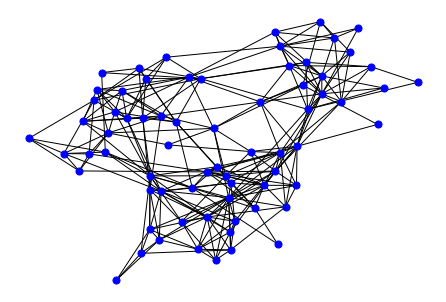

In [21]:
Highschool = pd.read_csv('data/social/out.moreno_highschool_highschool', sep=" ", header=None)
Highschool = Highschool.drop(Highschool.columns[2], axis=1)
load_the_network(Highschool)

## Classification of biological networks

    Metabolic networks from KEGG (2006)
    
    Description:
        109 metabolic networks of various species, as extracted from the Kyoto Encyclopedia of Genes and Genomes (KEGG) database in March 2006. Nodes are substances involved in enzymatic reactions present in the organism, and edges represent reactant-product pairs as extracted from the KEGG ligand database and matched against the present enzymes.
    
    Three were selected for classification: mpn, mpu, and uur.
    
    link -> https://networks.skewed.de/net/kegg_metabolic

   0   1
0  1   3
1  1   5
2  1   8
3  1   9
4  1  12

Number of nodes: 354
Number of edges: 856
X_net: [4.836158192090395, 76.30508474576271, 2.8738825775250136, 52.91665868683967, 0.06641020033474748, 3.493974168147117, 0.31862890763232715, 0.08499586672245994, 0.29358536750037423, 0.007085153886781582, 0.03303005628884732, -0.19426724396198677]

 GaussianNB() : Configuration model

 KNeighborsClassifier(metric='euclidean') : Barabási-Albert

 LogisticRegression(max_iter=1000) : Barabási-Albert

 RandomForestClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                          Measures  Importance
9   Average betweenness centrality    0.134229
0              Momment of degree 1    0.121594
4               Average clustering    0.112014
11                   Assortativity    0.104541
7         Average local efficiency    0.087137

 DecisionTreeClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                          Measures  Importance
9   Average between

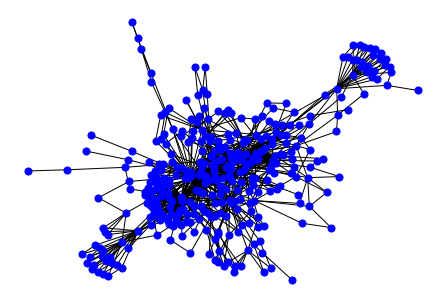

In [12]:
mpn = pd.read_csv('data/biological/links_mpn', sep="\t", header=None)
load_the_network(mpn)

   0   1
0  1   3
1  1   5
2  1   8
3  1   9
4  1  13

Number of nodes: 360
Number of edges: 887
X_net: [4.927777777777778, 85.32777777777778, 2.930874565434464, 61.04478395061729, 0.09122315782418622, 3.3961776539770967, 0.32665187322214295, 0.11619930595809926, 0.3018553814778624, 0.006693233670327089, 0.03268966545796318, -0.20727948835317517]

 GaussianNB() : Configuration model

 KNeighborsClassifier(metric='euclidean') : Barabási-Albert

 LogisticRegression(max_iter=1000) : Barabási-Albert

 RandomForestClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                         Measures  Importance
7        Average local efficiency    0.114828
4              Average clustering    0.104810
2                        Variance    0.098843
9  Average betweenness centrality    0.094572
0             Momment of degree 1    0.090876

 DecisionTreeClassifier(random_state=0) : Configuration model
Top 5 measures:
                        Measures  Importance
11                 Assor

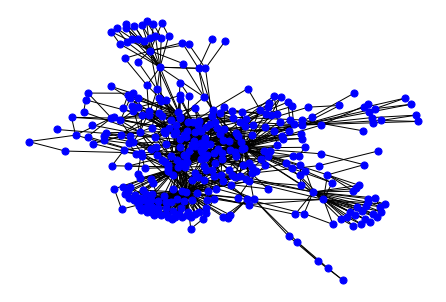

In [13]:
mpu = pd.read_csv('data/biological/links_mpu', sep="\t", header=None)
load_the_network(mpu)

   0   1
0  1   3
1  1   5
2  1   8
3  1   9
4  1  11

Number of nodes: 300
Number of edges: 712
X_net: [4.746666666666667, 76.27333333333333, 2.7997781676361613, 53.74248888888888, 0.09094206581834834, 3.319197324414716, 0.33320626957575267, 0.11511307754247053, 0.30860147338465765, 0.007782541357096364, 0.035964325192866076, -0.21260172705774685]

 GaussianNB() : Configuration model

 KNeighborsClassifier(metric='euclidean') : Barabási-Albert

 LogisticRegression(max_iter=1000) : Barabási-Albert

 RandomForestClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                          Measures  Importance
2                         Variance    0.107934
9   Average betweenness centrality    0.107111
0              Momment of degree 1    0.103211
11                   Assortativity    0.102695
10  Average eigenvector centrality    0.101130

 DecisionTreeClassifier(random_state=0) : Random Lobster
Top 5 measures:
                          Measures  Importance
9   Average between

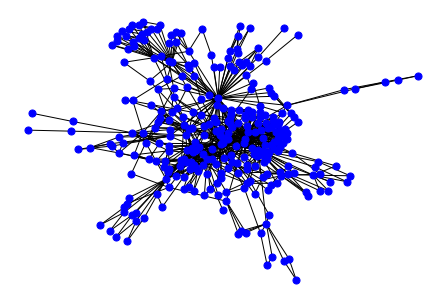

In [22]:
uur = pd.read_csv('data/biological/links_uur', sep="\t", header=None)
load_the_network(uur)

## Classification of technological network

### Software dependency

    Description:
        Networks of software dependecy. 
        
    'sjbullet' was selected for classification.
    
    link -> https://wwwlovre.appspot.com/publications.jsp?show=sgs#sgs

   0    1
0  0  234
1  0  234
2  0  234
3  0  279
4  0  279

Number of nodes: 249
Number of edges: 802
X_net: [6.4417670682730925, 103.5582329317269, 3.7596127295918, 62.061869969839194, 0.3814708247248524, 3.3614781707475063, 0.34145409081281436, 0.503760208964872, 0.30810085428546563, 0.009560640367398811, 0.04067848380584626, -0.18904300927738849]

 GaussianNB() : Configuration model

 KNeighborsClassifier(metric='euclidean') : Barabási-Albert

 LogisticRegression(max_iter=1000) : Barabási-Albert

 RandomForestClassifier(random_state=0) : Barabási-Albert
Top 5 measures:
                          Measures  Importance
11                   Assortativity    0.127038
10  Average eigenvector centrality    0.112617
9   Average betweenness centrality    0.107087
1              Momment of degree 2    0.096446
0              Momment of degree 1    0.089751

 DecisionTreeClassifier(random_state=0) : Small World
Top 5 measures:
                          Measures  Importance
11                  

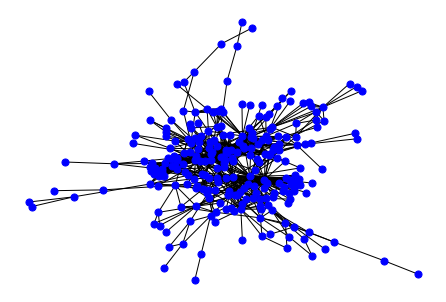

In [23]:
sjbullet = pd.read_csv('data/technological/sjbullet', sep=" ", header=None)
sjbullet = sjbullet.drop(sjbullet.columns[2], axis=1)
load_the_network(sjbullet)

### Central Chilean power grid (2016)

    Description:
        Three versions of the Chilean power grid, WT (with tap), WOT (without tap), and WOR (without-tap reduced), from 2016. Nodes are annotated with their type, spatial location, and activity levels (in two version: original and Kirchhoff-adjusted). Edges are annotated with the link capacity (kV) and length of the transmission line.
        
    WOR was selected for classification.
    
    link -> https://figshare.com/collections/An_in-depth_network_structural_data_and_hourly_activity_on_the_Central_Chilean_power_grid/4053374/1

   Source  Target
0       1       2
1       2       3
2       2       4
3       2       5
4       2       7

Number of nodes: 218
Number of edges: 527
X_net: [4.834862385321101, 46.04587155963303, 3.389448610954843, 22.669977274640186, 0.4043583021010233, 5.811651798926141, 0.23055234343401232, 0.42222104903643953, 0.18165891599354006, 0.022276165735769182, 0.022127283496244345, 0.010226850407217845]

 GaussianNB() : Configuration model

 KNeighborsClassifier(metric='euclidean') : Small World

 LogisticRegression(max_iter=1000) : Barabási-Albert

 RandomForestClassifier(random_state=0) : Small World
Top 5 measures:
                          Measures  Importance
10  Average eigenvector centrality    0.126346
2                         Variance    0.120432
9   Average betweenness centrality    0.110056
11                   Assortativity    0.103842
0              Momment of degree 1    0.098121

 DecisionTreeClassifier(random_state=0) : Small World
Top 5 measures:
                        

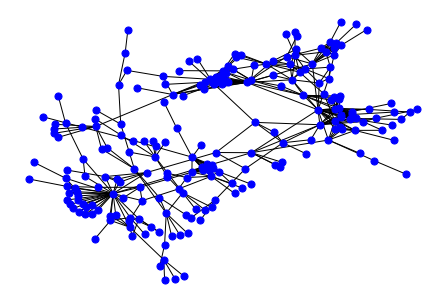

In [33]:
Chilean_WOR = pd.read_csv('data/technological/Reduced_edge.csv', sep=",")
Chilean_WOR = Chilean_WOR.drop(Chilean_WOR.columns[2:], axis=1)
#Chilean_WOR.head()
load_the_network(Chilean_WOR)

### R Dependency Network


    Description:
        A network of package dependency of R programming language for statistical computing. Nodes represent R packages and a directed edge indicates a dependency of one package on another.
        
    
    link -> https://icon.colorado.edu/#!/networks

     from        to
0  ADaCGH       cgh
1  ADaCGH    papply
2  ADaCGH       GDD
3  ADaCGH  waveslim
4  ADaCGH   cluster

Number of nodes: 2447
Number of edges: 5439
X_net: [4.445443400081733, 309.58806702084183, 3.007882731325622, 289.8260999975116, 0.11846712920262242, 3.5527107633590083, 0.30397536256909125, 0.1346481087998388, 0.2879015950658873, 0.001044053481946425, 0.010145153988419963, -0.16389910914700906]

 GaussianNB() : Configuration model

 KNeighborsClassifier(metric='euclidean') : Random Lobster

 LogisticRegression(max_iter=1000) : Random Lobster

 RandomForestClassifier(random_state=0) : Random Lobster
Top 5 measures:
                         Measures  Importance
9  Average betweenness centrality    0.130964
5    Average shortest path lenght    0.121233
8    Average closeness centrality    0.112332
7        Average local efficiency    0.095633
6              Network efficiency    0.090550

 DecisionTreeClassifier(random_state=0) : Random Lobster
Top 5 measures:
        

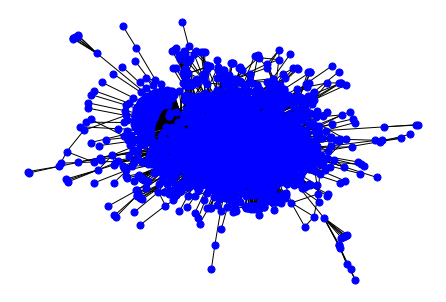

In [65]:
R_dependencies = pd.read_csv('data/technological/dependencies.csv', sep=",")
R_dependencies = R_dependencies[['from','to']]
R_dependencies = R_dependencies.dropna() #removing nan values from dataframe
load_the_network(R_dependencies)

# Hipótese: redes do mesmo tipo seguem o mesmo modelo.

  Não necessariamente redes do mesmo tipo seguem o mesmo modelo, como pode ser visto na classificação gerada pelas redes do tipo 'Technological' que apresentaram resultados bem diferentes. Nossos resultados para as redes biológicas obtiveram praticamente a mesma classificação, porém são todas redes metabólicas, então podemos dizer que redes biológicas desse tipo tendem a seguir um mesmo padrão estrutural. Já as redes sociais, também obtiveram resultados bastante parecidos, porém não é possível dizer que redes desse tipo tendem para um mesmo modelo.

# Bônus:

Para a classificação em modelo Barabási-Albert, as medidas que mais contribuiram foram average betweenness centrality e average eigenvector centrality. Para o modelo Small World, a assortativity. Para o modelo Random Lobster, average betweenness centrality e momment of degree 2. Para o modelo Erdos-Renyi, o momment of degree 1. E para o configuration model, a assortativity.